In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 1,
                 "param_name_str" : "t1t2",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "num_val_pts": 20,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# df_best["Min Obj Act"].iloc[2]
# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
11,5,1,5.342819,0.666667,0.0,"[-1.1923314387327575, 1.2550420118452932]",0.86575,0.078749,"[1.0622882964925582, -0.9657215500034723]",0.078749,"[1.0622882964925582, -0.9657215500034723]",0.14952,3,A1,2,0.299039,0.071097
240,7,1,1.675753,1.0,0.0,"[-0.12469795110750015, 1.8446633771315404]",1.337255,-1.118795,"[0.9078567554482146, -0.9156740615532917]",-1.118795,"[0.9078567554482146, -0.9156740615532917]",0.107567,1,B1,2,0.215134,0.124905
499,3,4,0.000002,2.0,0.000002,"[1.0001750084083774, -0.9997719454291544]",0.0,0.000001,"[1.0001041838227045, -0.9998630819205805]",0.000001,"[1.0001041838227045, -0.9998630819205805]",1.737641,4,A2,5,8.688207,0.000172
5137,13,99,-20.831986,0.5,4.253996,"[1.000003510958464, -0.9999952747577525]",-23.00006,-21.056092,"[1.0000037983732255, -0.9999958961327475]",-21.056092,"[1.0000037983732255, -0.9999958961327475]",73.386999,3,B2,100,7338.699937,0.000006
5271,1,1,5.342819,1.124104,0.0,"[-0.9023643249400515, 1.009907260734813]",0.000554,0.006628,"[1.025695915986367, -0.9991365280015173]",0.006628,"[1.025695915986367, -0.9991365280015173]",15.352817,4,C2,2,30.705635,0.025710


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

2b0d1ee15911cd245f17a7d10a7abf3e
b0e257d6e76025909e364903b3b792ee
d0c8b17229671998f3ffdab06c79e1f9
fdc2673ac83f3d0cf5b3b969a3e80825
9042085b58a00b76d6c2ae0a20cfe9f3


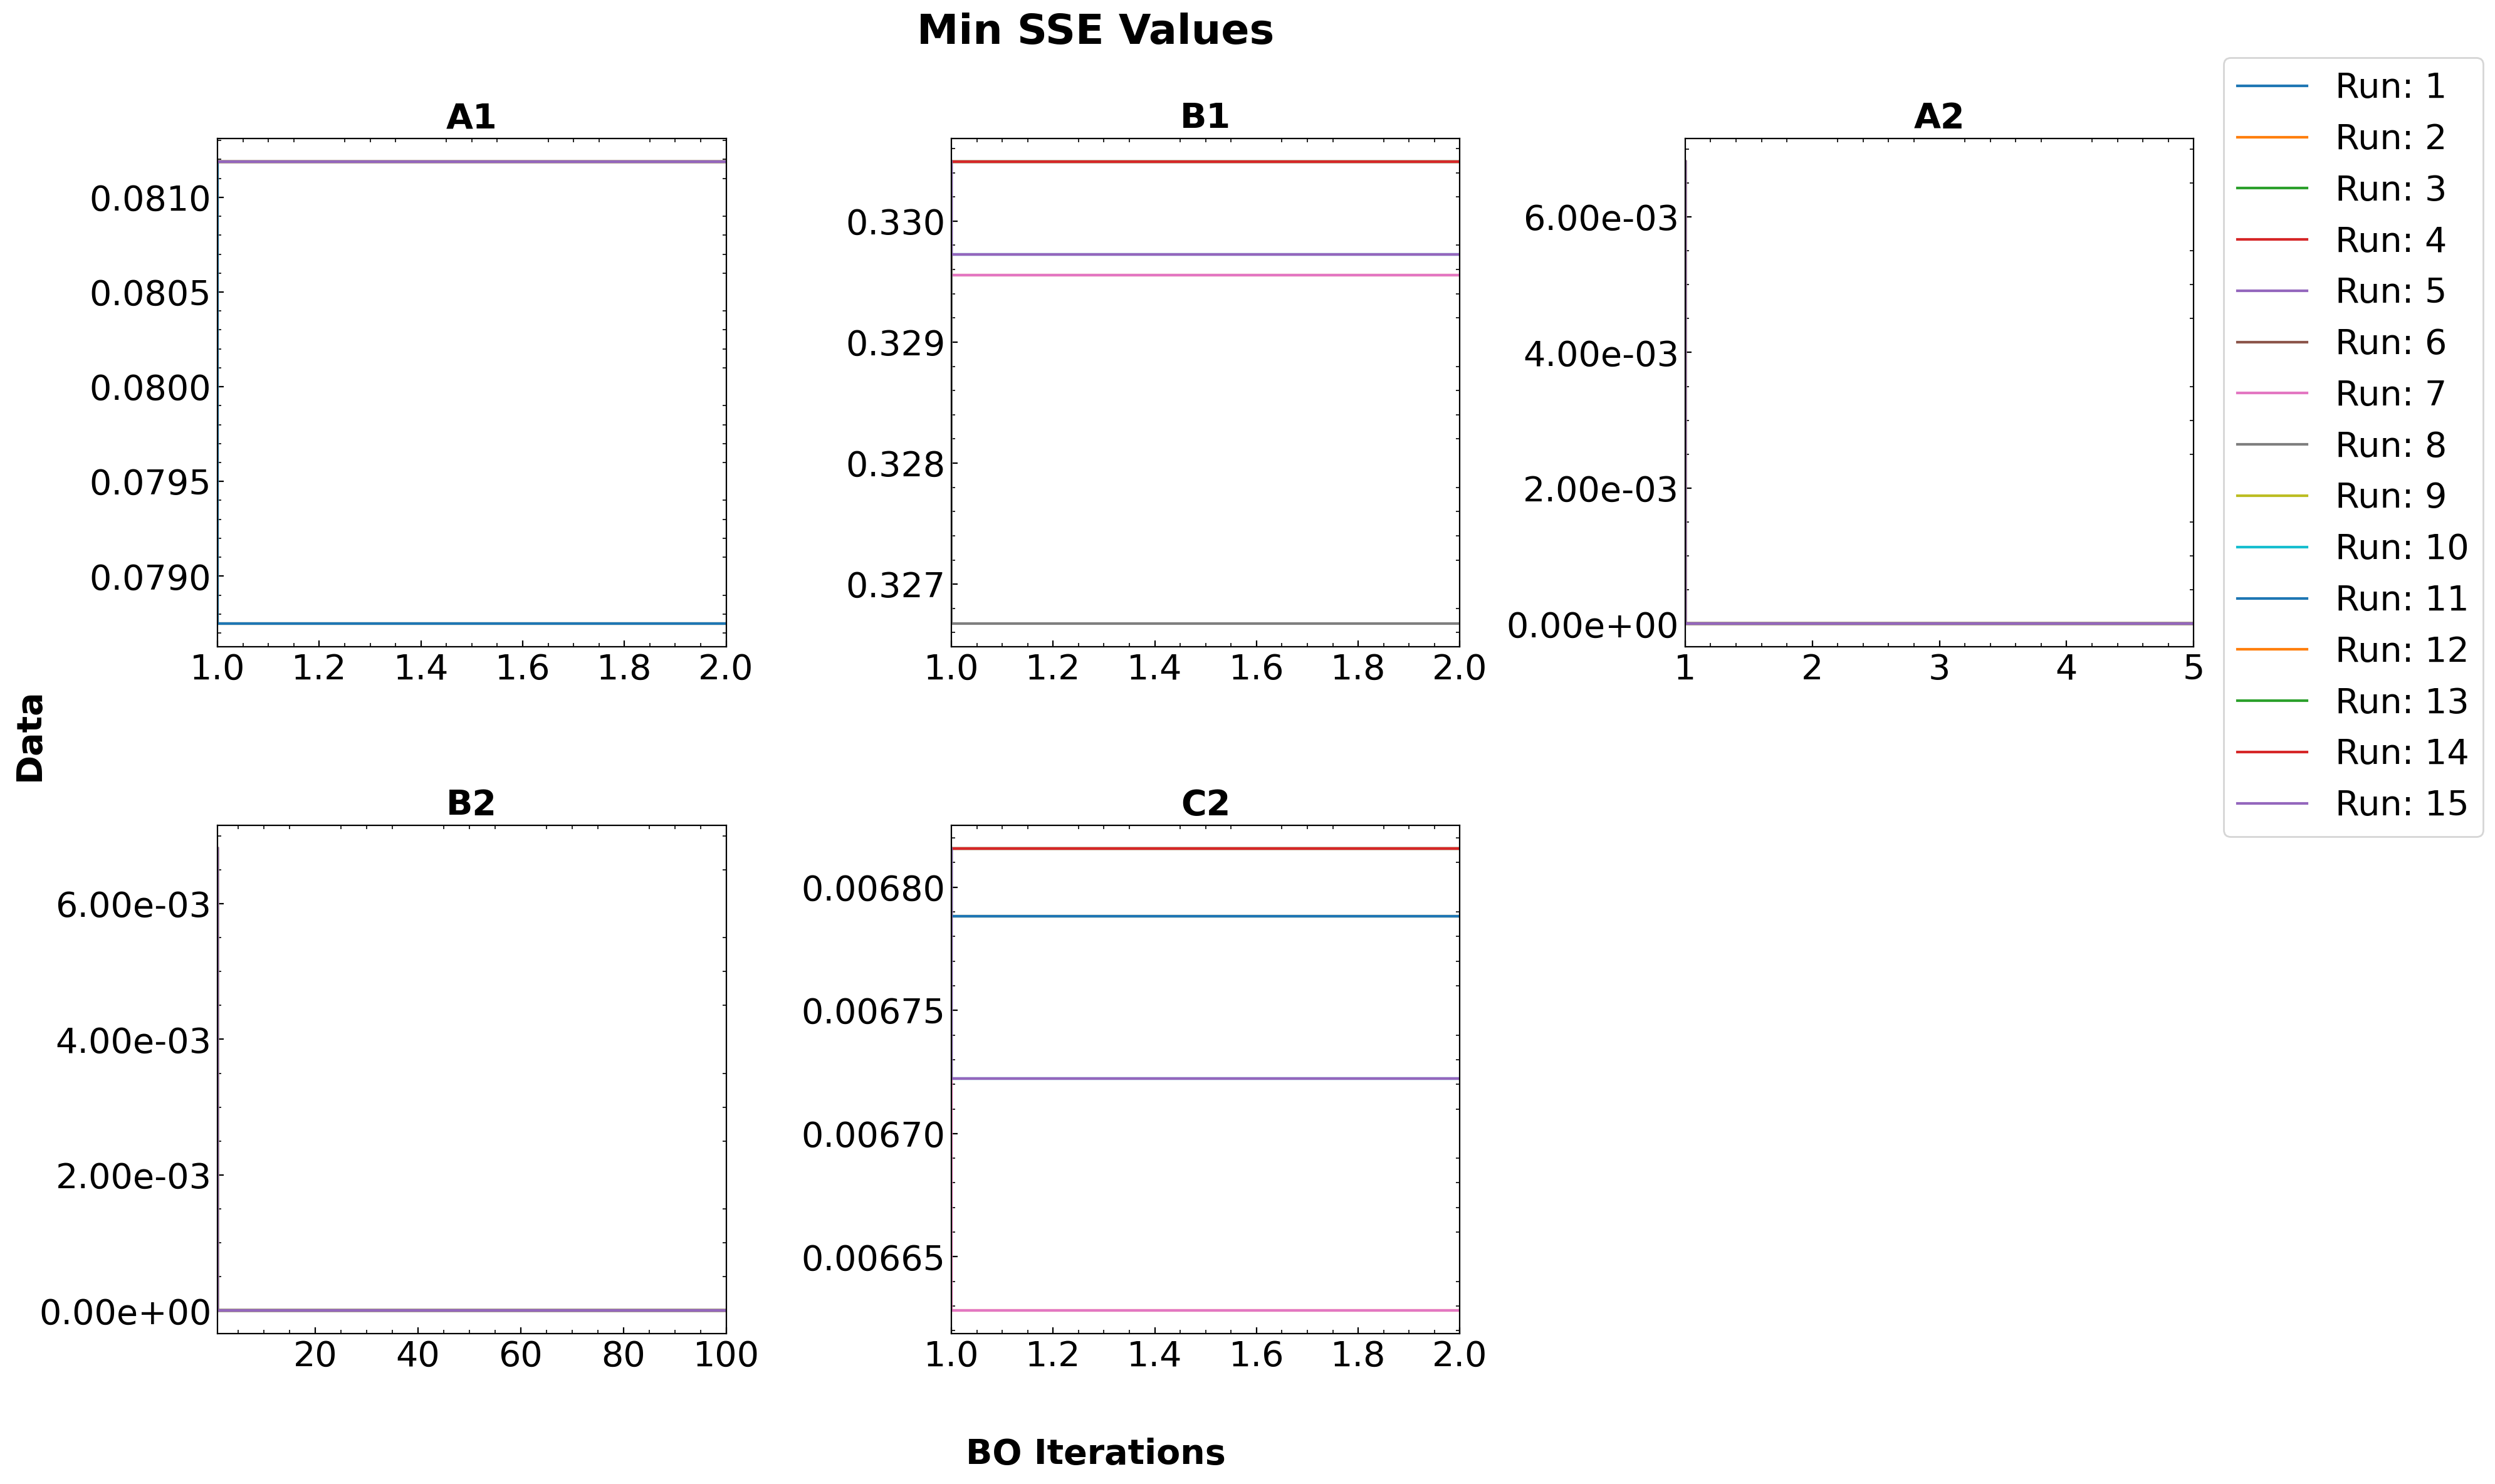

In [5]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2" ]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["Min SSE"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Min SSE Values"
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_compare_method_ei_sse(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

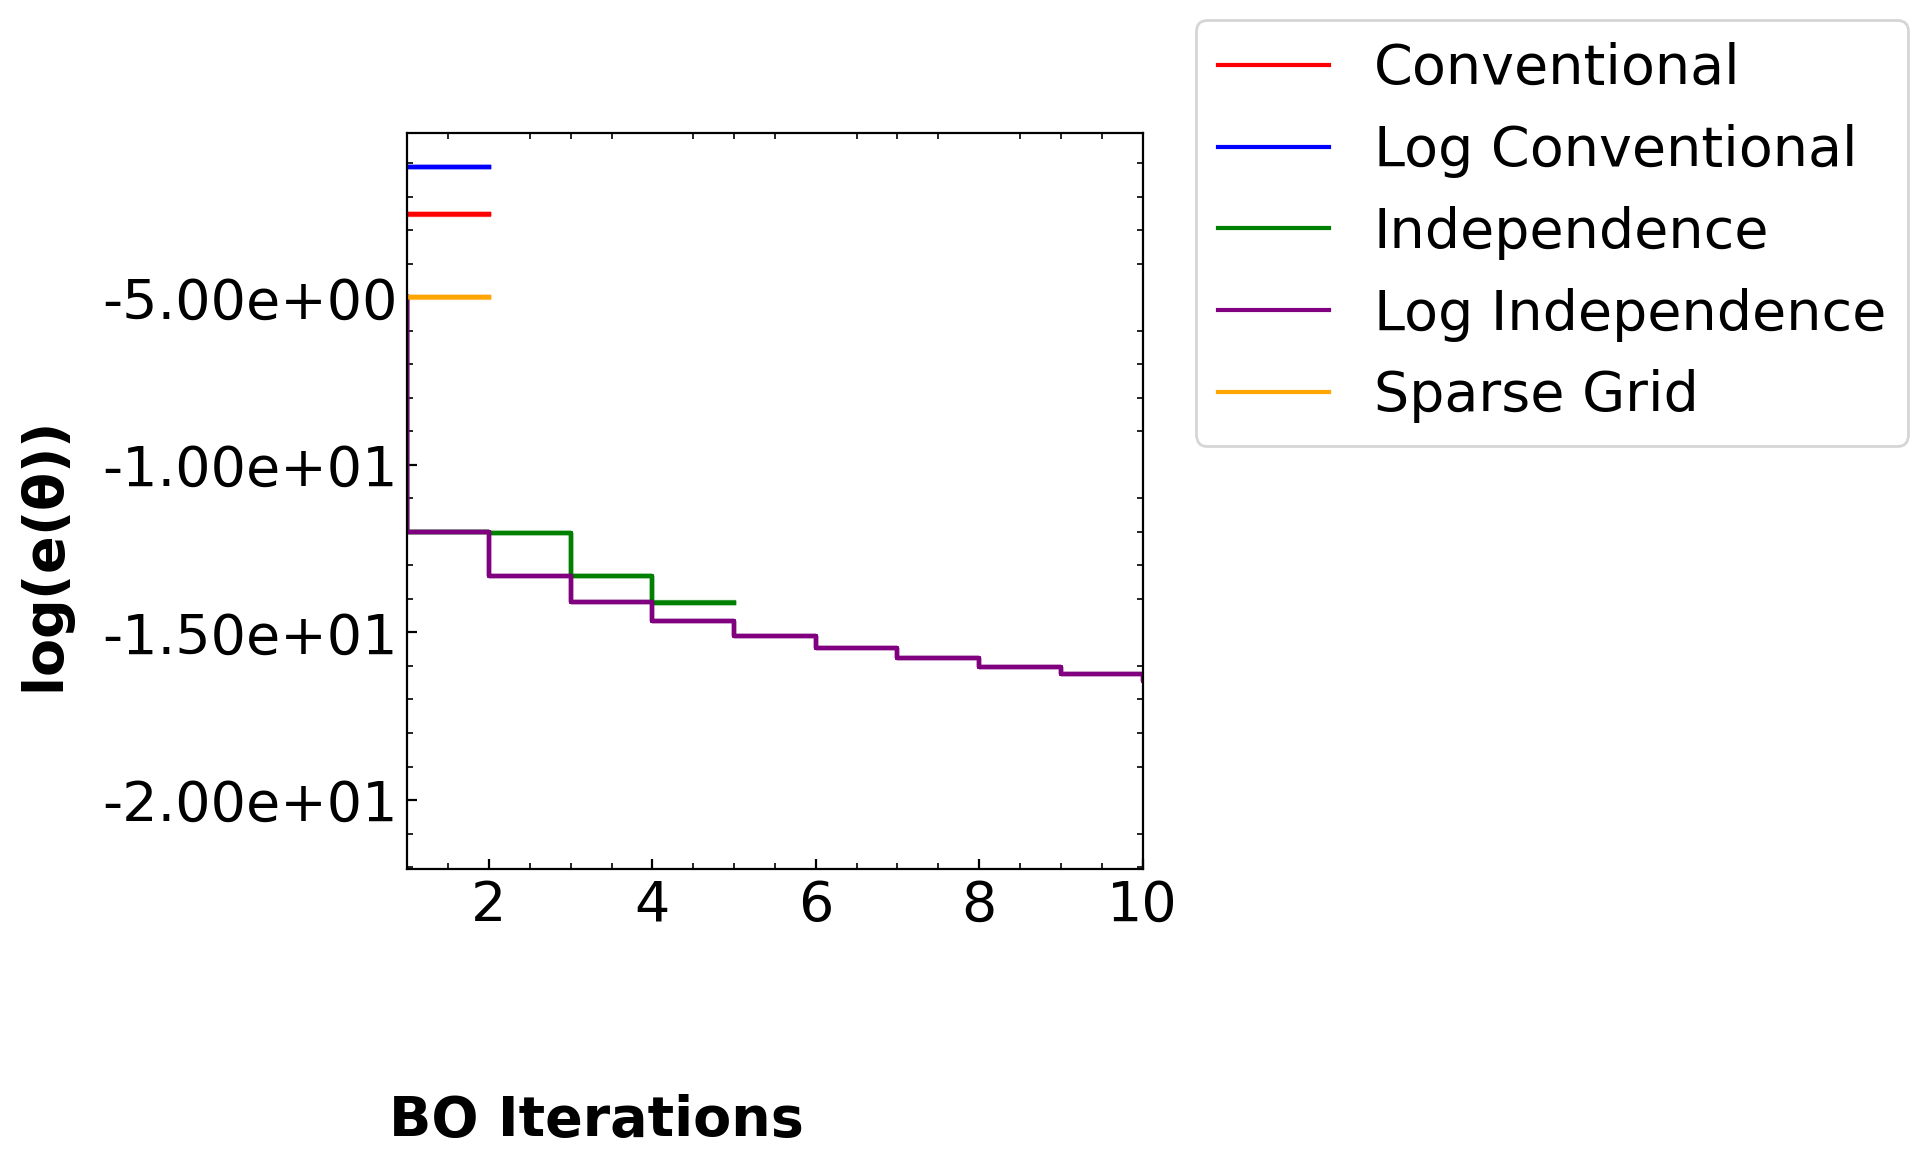

In [6]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2" ]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["Min SSE"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = r"$\mathbf{log(e(\theta))}$"
# title = "Min SSE Values"
title = None
save_path = None
log_data = True

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_method_sse_one_plot(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)